In [1]:
from functions import vectorize_y_ser

In [2]:
import datetime

In [3]:
import nltk
import string

In [4]:
import re

In [5]:
import pickle

In [6]:
import pandas as pd
import numpy as np

In [7]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [9]:
from collections import Counter

In [10]:
from imblearn.under_sampling import RandomUnderSampler

In [11]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# NLP Pipeline 

![](images/pipeline-walkthrough1.png)

Below is a to do list when converting text into vector form: 

**Clean text and Create a Bag of Words (BoW)**
>1. Lowercase the text
2. Tokenize 
3. Strip out punctuation or undesirable text
4. Remove Stopwords 
5. Stemming or Lemmatizing
6. Compute N-Grams
7. Use this to create BoW

**Vectorize BoW**
>8. Term Frequencies
9. Document Frequencies
10. TF-IDF
11. Normalize vectors

Let's go through both what each of these steps are and how to do them in python with the following corpus of comments about data science...
 

In [12]:
# function to vectorize the type_of_material series into a y target vector.
def vectorize_y_ser(ser):
    y = ser.copy()
    y.replace({'Op-Ed': 1,'News': 0}, inplace=True)
    return y

In [13]:
#rate of correct predictions out of total predictions
def metrics_(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tn + fn + tp + fp)
    print(f'Accuracy: {round(accuracy, 2)}')
    recall = (tp) / (tp + fn)
    print(f'Recall: {round(recall, 2)}')
    precision = (tp) / (tp + fp)
    print(f'Precision: {round(precision, 2)}')
    print(f'TN:{tn} FP:{fp} FN:{fn} TP:{tp}')
    return (accuracy, recall, precision)

In [14]:
#prints number of features, stop words and parameters for vectorizer
def vectorizer_parameters(vectorizer):
    #features
    feat_names = vectorizer.get_feature_names()
    num_feat = len(feat_names)
    
    #stop words
    stop_words = vectorizer.stop_words_
    num_stop = len(stop_words)

    params = vectorizer.get_params()
    
    print(f'Number of features: {num_feat}, Numbers of stop words: {num_stop}')
      
    for key, val in params.items():
        print(f'{key}: {val}')

In [15]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~”’“':
            document = document.replace(char, " ") 
    return document

In [16]:
#combine print, type, text columns in the list
def printed_file(file):
    print_cols = ['_id','print_page','pub_date','keywords','type_of_material','lead_paragraph','text']    
    df = pd.read_csv(file, usecols=print_cols, index_col='_id', low_memory=False)
    df = df[df.print_page.isna() == False]
    df = df[~df.text.isna() == True]
    return df

In [17]:
#combine print, type, text columns in the list
def printed_df(df):
    print_cols = ['print_page','pub_date','keywords','type_of_material','lead_paragraph','text']    
    df = df[print_cols]
    df = df[df.print_page.isna() == False]
    df = df[~df.text.isna() == True]
    return df

In [18]:
#returns articles w/ 'United States Politics and Government' as a keyword
def return_pol_gov(row):
    list_dict = eval(row.keywords)
    for (dic) in (list_dict):
        if dic.get('value') == 'United States Politics and Government':
            return True

In [19]:
def filter_keyword(df, keyword='United States Politics and Government'):
    df[keyword] = df.apply(return_pol_gov, axis=1)
    df = df[df[keyword] == True]
    return df

In [20]:
#returns shape of news and oped
def oped_v_news(df):
    df.type_of_material.hist()
    news = sum(df.type_of_material == "News")
    oped = sum(df.type_of_material == "Op-Ed")
    print(f'News: {news} Oped: {oped}, Total: {oped+news}, Op-Ed {round(oped/(oped+news), 2)} of total')
    #plt.savefig('img/oped_news_hist.png')

In [21]:
#split article and return quote
def return_quote(document):
    article = []
    quote_list = []
    
    open_quote = "“"
    close_quote = "”"
    
    close_split = document.split(close_quote)
    
    for string in close_split:

        quote = string.split(open_quote)
        article.append(quote.pop(0))
        quote_list += quote
    
    article = " ".join(article)
    quotation = " ".join(quote_list)
        
    return(quotation)

In [22]:
#split article and return quote
def return_article(document):
    article = []
    quote_list = []
    
    open_quote = "“"
    close_quote = "”"
    
    close_split = document.split(close_quote)
    
    for string in close_split:

        quote = string.split(open_quote)
        article.append(quote.pop(0))
        quote_list += quote
    
    article = " ".join(article)
    quotation = " ".join(quote_list)
    
    return(article)

In [85]:
df_list_auto = []
for num in range(2017,2021):
    df_list_auto.append(f'/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_{num}.csv')

In [86]:
df_list_auto

['/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2017.csv',
 '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2018.csv',
 '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2019.csv',
 '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2020.csv']

In [92]:
files = []
for file in df_list_auto:
    df = printed_file(file)
    files.append(df)
    

In [98]:
data = pd.concat(files)

In [99]:
data.columns

Index(['lead_paragraph', 'keywords', 'pub_date', 'type_of_material',
       'print_page', 'text'],
      dtype='object')

In [100]:
%%time
df = data.copy()

CPU times: user 10 ms, sys: 1.4 ms, total: 11.4 ms
Wall time: 10.8 ms


In [101]:
df.shape

(121876, 6)

In [102]:
df = printed_df(df)

In [103]:
df.head()

,print_page,pub_date,keywords,type_of_material,lead_paragraph,text
_id,,,,,,
nyt://article/92f2b7e3-3bfe-5c93-a594-98f2d05f67f1,18,2017-03-01T00:43:00+0000,"[{'name': 'organizations', 'value': 'Republica...",News,"WASHINGTON — Congressional Republicans, racked...","WASHINGTON — Congressional Republicans, racked..."
nyt://article/95c25931-04d1-5524-96e9-39261ed45ca5,3,2017-03-01T00:45:29+0000,"[{'name': 'organizations', 'value': 'Arconic I...",News,"Arconic, the aerospace and automotive parts ma...","Arconic, the aerospace and automotive parts ma..."
nyt://article/12d4f10c-0886-586b-ae39-b25d8a6b368c,10,2017-03-01T00:46:46+0000,"[{'name': 'persons', 'value': 'Obama, Barack',...",News,PARIS — Many voters in France cannot identify ...,PARIS — Many voters in France cannot identify ...
nyt://article/6f3892d1-33c7-57f8-9b5b-464184e8d676,21,2017-03-01T01:00:05+0000,"[{'name': 'glocations', 'value': 'Second Avenu...",News,Dear Diary:,"Dear Diary:Many years ago, while visiting my b..."
nyt://article/8f577a28-5b4d-5af6-8631-caa3861a5748,3,2017-03-01T01:06:03+0000,"[{'name': 'subject', 'value': 'Extraordinary R...",News,ROME — A 10-year legal battle over the “extrao...,ROME — A 10-year legal battle over the “extrao...


In [104]:
df.text.iloc[0]

'WASHINGTON — Congressional Republicans, racked by divisions over health care, taxes and spending, are increasingly desperate for leadership from the White House to unite the party and point the way toward consensus.But presidential leadership does not appear to be forthcoming, leaving the party largely paralyzed at a moment it had thought would be full of legislative activity.“The White House is huge,” said Senator John Thune, Republican of South Dakota. “The president is the only person who can sign a bill into law, so he’s the guy that ultimately holds the whip hand when it comes to this getting done.”As congressional leaders struggle to clear the first major legislative hurdle of the Trump era — a bill to repeal and replace the Affordable Care Act — their talks with the White House, though not infrequent, have failed to advance any coherent, cohesive policy prescription. Repealing the health care law is the Republicans’ first step toward enacting their broader agenda.So far, Presid

In [105]:
last_check_before_split = (df.iloc[0])
last_check_before_split

print_page                                                         18
pub_date                                     2017-03-01T00:43:00+0000
keywords            [{'name': 'organizations', 'value': 'Republica...
type_of_material                                                 News
lead_paragraph      WASHINGTON — Congressional Republicans, racked...
text                WASHINGTON — Congressional Republicans, racked...
Name: nyt://article/92f2b7e3-3bfe-5c93-a594-98f2d05f67f1, dtype: object

News: 113679 Oped: 8197, Total: 121876, Op-Ed 0.07 of total


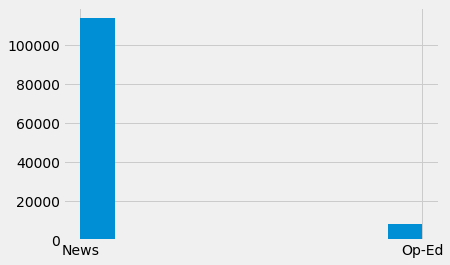

In [106]:
oped_v_news(df)

# drop na

In [107]:
df.shape

(121876, 6)

In [108]:
df = df.dropna()

In [109]:
df.shape

(121601, 6)

# X, y

In [110]:
#define X. X is currently pandas series of unsplit strings
X = df.text

In [111]:
#turn series into list...
corpus = list(X)

In [112]:
corpus[0]

'WASHINGTON — Congressional Republicans, racked by divisions over health care, taxes and spending, are increasingly desperate for leadership from the White House to unite the party and point the way toward consensus.But presidential leadership does not appear to be forthcoming, leaving the party largely paralyzed at a moment it had thought would be full of legislative activity.“The White House is huge,” said Senator John Thune, Republican of South Dakota. “The president is the only person who can sign a bill into law, so he’s the guy that ultimately holds the whip hand when it comes to this getting done.”As congressional leaders struggle to clear the first major legislative hurdle of the Trump era — a bill to repeal and replace the Affordable Care Act — their talks with the White House, though not infrequent, have failed to advance any coherent, cohesive policy prescription. Repealing the health care law is the Republicans’ first step toward enacting their broader agenda.So far, Presid

In [113]:
# define y as a series of op-ed or news
y = df.type_of_material

In [114]:
vectorize_y_ser(y)

_id
nyt://article/92f2b7e3-3bfe-5c93-a594-98f2d05f67f1    0
nyt://article/95c25931-04d1-5524-96e9-39261ed45ca5    0
nyt://article/12d4f10c-0886-586b-ae39-b25d8a6b368c    0
nyt://article/6f3892d1-33c7-57f8-9b5b-464184e8d676    0
nyt://article/8f577a28-5b4d-5af6-8631-caa3861a5748    0
                                                     ..
nyt://article/a4383433-5708-530c-bf78-2ec5ee0d96cd    0
nyt://article/aff30fb5-0177-5fed-b8b5-55656f2672f6    0
nyt://article/d67ea079-eaf8-5e69-a77c-3138a3fc91cb    0
nyt://article/5af20a48-6f66-5bae-a9fd-948268ed38cf    0
nyt://article/3aea061c-d11a-53d1-8480-c0b163740360    0
Name: type_of_material, Length: 121601, dtype: int64

In [115]:
%%time
# vectorize y in to (1, 0) (op-ed, news)
y = vectorize_y_ser(y)

CPU times: user 29.1 ms, sys: 1.54 ms, total: 30.7 ms
Wall time: 29.5 ms


In [116]:
y.value_counts()

0    113415
1      8186
Name: type_of_material, dtype: int64

In [117]:
y.shape
X.shape

(121601,)

# remove stop words

# stemming/lemmatization

In [118]:
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

In [119]:
# %%time
# def snowball_tokenize(doc):
#     snowball = SnowballStemmer('english')
#     return [snowball.stem(word) for word in word_tokenize(doc.lower())]

In [120]:
%%time
def wordnet_tokenize(doc):
    wordnet = WordNetLemmatizer()
    return  [wordnet.lemmatize(word) for word in word_tokenize(doc.lower())]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


# vectorizer

# WORDNET tfidf

In [121]:
import string

In [122]:
print(string.punctuation)
print('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [123]:
# nytimes_quotes = "”“"
# nytimes_punctuation = "—’"

In [124]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~':
            document = document.replace(char, " ")
        if char == '’':
            document = document.replace(char, "")
    return document

In [125]:
stop_words_nlp = ['isn']

In [126]:
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

In [127]:
stop_words = alphabet# + stop_words_nlp

In [128]:
%%time
#create vectorizer

vectorizer = TfidfVectorizer(#input='content', 
#                 encoding='utf-8', 
#                 decode_error='strict', 
#                 strip_accents='ascii', 
#                 lowercase=True, 
                 preprocessor=punc_strip, 
                 tokenizer=wordnet_tokenize, 
#                 analyzer='word', 
                 stop_words=stop_words,
#                 token_pattern='(?u)\b\w\w+\b', 
#                 ngram_range=(1, 2), 
                 max_df=0.85, 
                 min_df=0.1, 
                 max_features=None, 
#                 vocabulary=None, 
#                 binary=False, 
#                 dtype=<class 'numpy.float64'>, 
#                 norm='l2', 
#                 use_idf=True, 
#                 smooth_idf=True, 
#                 sublinear_tf=False
)

CPU times: user 7.36 ms, sys: 1.08 ms, total: 8.44 ms
Wall time: 8.41 ms


# test, train, split

In [129]:
#test, train, split

In [130]:
%%time
#test, train, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train = vectorizer.fit_transform(X_train)

X_test = vectorizer.transform(X_test)

(91200,) (30401,) (91200,) (30401,)
CPU times: user 15min 32s, sys: 11.3 s, total: 15min 43s
Wall time: 15min 49s


In [131]:
X_train.shape

(91200, 835)

In [132]:
X_test.shape

(30401, 835)

# count vectorizer

In [133]:
# count_vectorizer = CountVectorizer(strip_accents='None',
#                                    lowercase=True,
#                                    tokenizer=snowball_tokenize,
#                                    stop_words='english',
#                                    max_features=None)

# balance classes

In [134]:
%%time
#balance the classes

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

#X, y --> X_resampled, y_resampled
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))
print(rus)

[(0, 6141), (1, 6141)]
RandomUnderSampler(random_state=0)
CPU times: user 46.1 ms, sys: 6.42 ms, total: 52.5 ms
Wall time: 51.3 ms


# random forest classifier

In [135]:
%%time
print(datetime.datetime.now())
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)

2021-01-12 11:01:08.833504
CPU times: user 519 µs, sys: 59 µs, total: 578 µs
Wall time: 564 µs


In [136]:
rf_clf.fit(X_resampled, y_resampled)
y_pred = rf_clf.predict(X_test)
y_pred.shape

(30401,)

### metrics y_pred

In [137]:
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel()

In [138]:
print(y_test.shape)
print(y_pred.shape)

(30401,)
(30401,)


In [139]:
metrics_(tn, fp, fn, tp)

Accuracy: 0.88
Recall: 0.89
Precision: 0.34
TN:24856 FP:3500 FN:217 TP:1828


(0.8777342850564126, 0.8938875305623472, 0.3430930930930931)

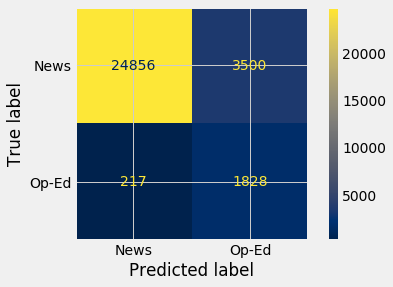

In [140]:
class_names = ["News", "Op-Ed"]
plot_confusion_matrix(estimator=rf_clf,
                      X=X_test,
                      y_true=y_test,
                      display_labels=class_names,
                      cmap='cividis')
plt.savefig('img/confusion_matrix.png');

# vectorizer parameters

In [141]:
vectorizer_parameters(vectorizer)

Number of features: 835, Numbers of stop words: 338495
analyzer: word
binary: False
decode_error: strict
dtype: <class 'numpy.float64'>
encoding: utf-8
input: content
lowercase: True
max_df: 0.85
max_features: None
min_df: 0.1
ngram_range: (1, 1)
norm: l2
preprocessor: <function punc_strip at 0x7fd25ebb67a0>
smooth_idf: True
stop_words: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
strip_accents: None
sublinear_tf: False
token_pattern: (?u)\b\w\w+\b
tokenizer: <function wordnet_tokenize at 0x7fd25ebb6b00>
use_idf: True
vocabulary: None


# important features

### feature imporance

2021-01-12 11:01:12.337644
CPU times: user 316 ms, sys: 16.5 ms, total: 332 ms
Wall time: 332 ms


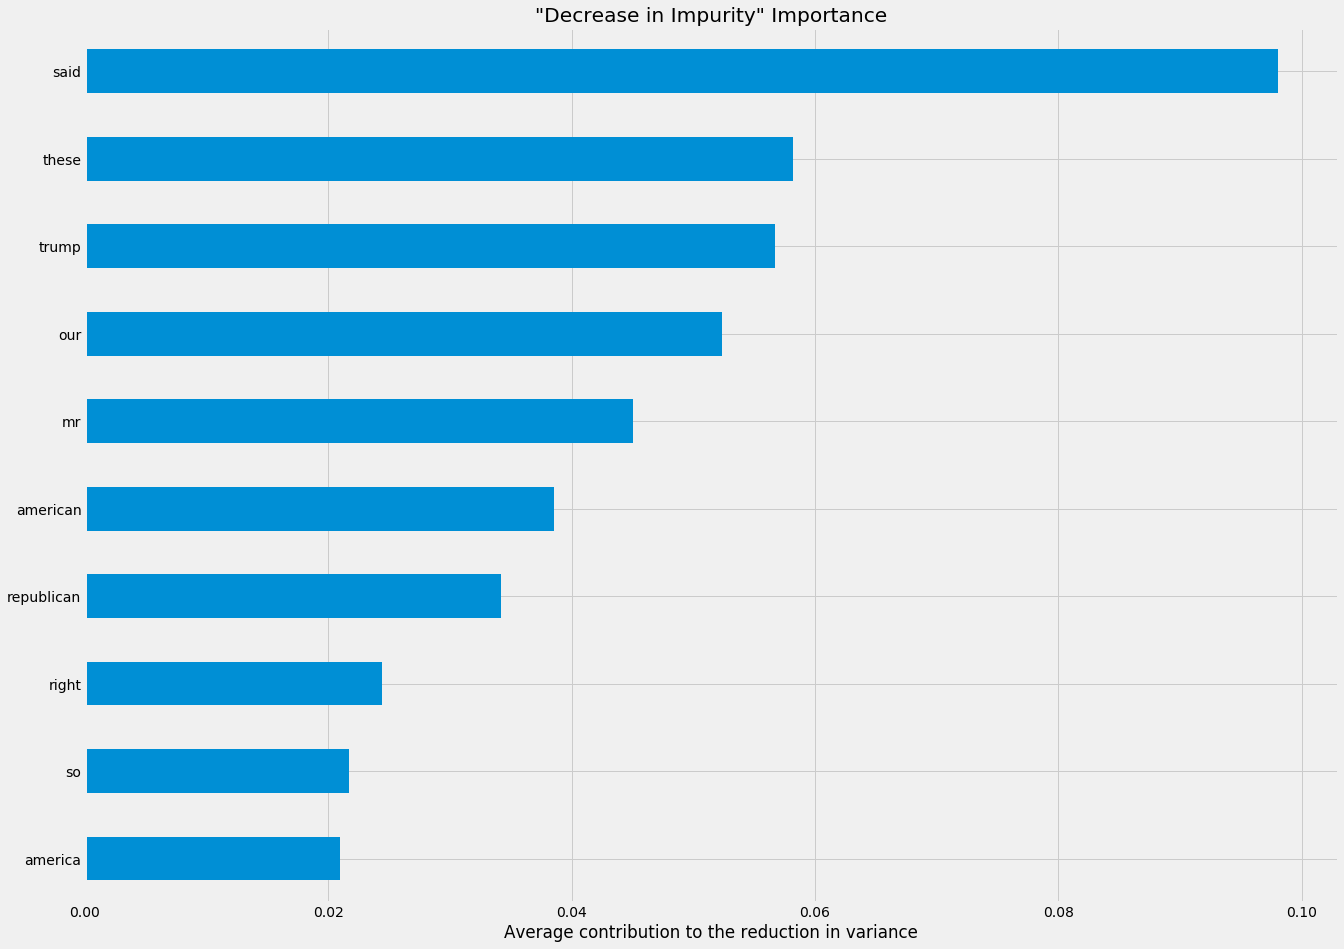

In [142]:
%%time
print(datetime.datetime.now())

feat_names = vectorizer.get_feature_names()
feature_import = rf_clf.feature_importances_

feat_scores = pd.Series(feature_import, index=feat_names)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-10:].plot(kind='barh', figsize=(20,15))
ax.set_title('"Decrease in Impurity" Importance')
ax.set_xlabel('Average contribution to the reduction in variance')
plt.savefig('img/feature_imporance.png');

In [143]:
feat_scores[-10:].index

Index(['america', 'so', 'right', 'republican', 'american', 'mr', 'our',
       'trump', 'these', 'said'],
      dtype='object')

In [144]:
count_df = df[['text', 'type_of_material']]
oped = count_df[count_df['type_of_material'] == "Op-Ed"]
news = count_df[count_df['type_of_material'] == "News"]

In [145]:
print(oped.shape)
print(news.shape)

(8186, 2)
(113415, 2)


In [146]:
oped_string = oped.text.str.cat(sep = " ")
num_oped_string = len(oped_string)
print(num_oped_string)

50116334


In [147]:
news_string = news.text.str.cat(sep = " ")
num_news_string = len(news_string)
print(num_news_string)

709617069


# counting

In [148]:
top_10 = feat_scores[-10:].index

In [149]:
%%time
oped_list = [word for word in oped_string.split() if word in list(top_10)]
oped_ed_counter = Counter(oped_list)
oped_ed_counter.items()

CPU times: user 14.7 s, sys: 460 ms, total: 15.2 s
Wall time: 15.4 s


dict_items([('so', 13660), ('our', 20779), ('said', 6656), ('these', 8947), ('right', 4795), ('republican', 29), ('trump', 17)])

In [150]:
%%time
news_list = [word for word in news_string.split() if word  in list(top_10)]
news_counter = Counter(news_list)
news_counter.items()

CPU times: user 3min 35s, sys: 21.3 s, total: 3min 56s
Wall time: 4min 4s


dict_items([('said', 542394), ('so', 141622), ('these', 65626), ('right', 42012), ('our', 102180), ('trump', 101), ('republican', 107), ('american', 2), ('mr', 1)])

# merge dictionary

In [151]:
# merge_dic.val[0] = news
# merge_dic.val[1] = oped

merge_dic = {}
for key, oped_val in oped_ed_counter.items():
    news_val = news_counter.get(key)
    merged_values = (news_val, oped_val)
    merged_values_set = set(merged_values)
    merge_dic[key] = merged_values_set

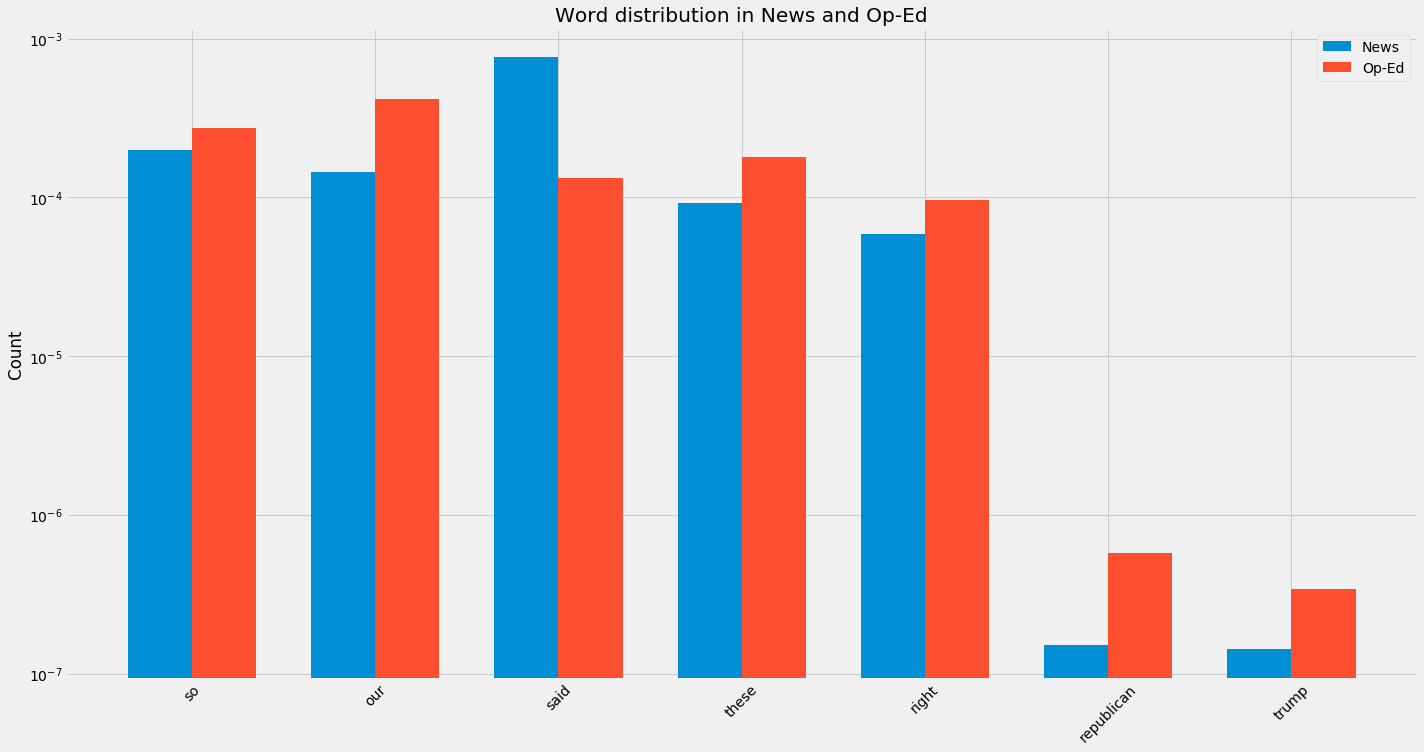

In [163]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

merge_dic = {}
for key, oped_val in oped_ed_counter.items():
    news_val = news_counter.get(key)
    merged_values = (news_val, oped_val)
    merge_dic[key] = merged_values

keys = []
news_counts = []
oped_counts = []
    
for k, v in merge_dic.items():
    keys.append(k)
    news_counts.append(v[0]/num_news_string)
    oped_counts.append(v[1]/num_oped_string)

x = np.arange(len(keys))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, news_counts, width, label='News')
rects2 = ax.bar(x + width/2, oped_counts, width, label='Op-Ed')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Word distribution in News and Op-Ed')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(keys)
ax.legend()

# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

# oped most common 

In [153]:
top_10

Index(['america', 'so', 'right', 'republican', 'american', 'mr', 'our',
       'trump', 'these', 'said'],
      dtype='object')

In [154]:
%%time
oped_list_features = [word for word in oped_string.split() if word in list(top_10)]
oped_ed_count_total = Counter(oped_list_features)

CPU times: user 14.8 s, sys: 446 ms, total: 15.2 s
Wall time: 15.6 s


In [155]:
%%time
news_list_features = [word for word in news_string.split() if word in list(top_10)]
news_counter_total = Counter(news_list_features)

CPU times: user 3min 26s, sys: 10 s, total: 3min 36s
Wall time: 3min 41s


In [156]:
%%time
merge_dic_total = {}
for key, oped_val in oped_ed_count_total.items():
    news_val = news_counter_total.get(key)
    merged_values_total = (news_val, oped_val)
    merge_dic_total[key] = merged_values_total

news_words = []
oped_words = []
    
for k, v in merge_dic_total.items():
    if v[0]/num_news_string > v[1]/num_oped_string:
        news_words.append(k)
    else:
        oped_words.append(k)

CPU times: user 58 µs, sys: 1.05 ms, total: 1.11 ms
Wall time: 2.66 ms


In [159]:
len(top_10)

10

In [160]:
print(len(news_words))
print(len(oped_words))

1
6


In [161]:
news_words

['said']

In [162]:
oped_words

['so', 'our', 'these', 'right', 'republican', 'trump']

In [ ]:
print(num_oped_string)
print(num_news_string)

In [ ]:
# import matplotlib
# import matplotlib.pyplot as plt
# import numpy as np


# labels = oped_ed_counter.keys()
# #news_labels = news_counter.keys()

# oped_counts = oped_ed_counter.values()
# #news_counts = news_counter.values()

# x = np.arange(len(labels))  # the label locations
# width = 0.5  # the width of the bars

# fig, ax = plt.subplots(figsize=(10,10))
# rects1 = ax.bar(x - width/2, oped_counts, width, label='oped')
# #rects2 = ax.bar(x + width/2, news_counts, width, label='news')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# #ax.set_ylabel('Scores')
# ax.set_title('words in oped corpus')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# fig.tight_layout()
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
# import matplotlib
# import matplotlib.pyplot as plt
# import numpy as np


# labels = news_counter.keys()
# #news_labels = news_counter.keys()

# oped_counts = news_counter.values()
# #news_counts = news_counter.values()

# x = np.arange(len(labels))  # the label locations
# width = 0.5  # the width of the bars

# fig, ax = plt.subplots(figsize=(10,10))
# rects1 = ax.bar(x - width/2, oped_counts, width, label='news')
# #rects2 = ax.bar(x + width/2, news_counts, width, label='news')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# #ax.set_ylabel('Scores')
# ax.set_title('words in news corpus')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# fig.tight_layout()
# plt.xticks(rotation=90)
# plt.show()

### permutation importance

In [ ]:
# %%time
# print(datetime.datetime.now())
# r = permutation_importance(rf_clf, X_test.toarray(), y_test, n_repeats=30, random_state=0)

In [ ]:
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feat_names[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

In [ ]:
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feat_names[i]:<20}")
# #               f"{r.importances_mean[i]:.3f}"
# #               f" +/- {r.importances_std[i]:.3f}")

In [ ]:
# len(feat_names)

In [ ]:
#corpus[0]

# make a plot

In [ ]:
#y

In [ ]:
#min_df = np.linspace(0,.4,5)

In [ ]:
#min_df

In [ ]:
#corpus[0]

# min_df_plot

In [ ]:
# #%%time
# #num_feat_min = []

# #min_df = np.linspace(0.01,0.5,5)

# for val in min_df:
#     vectorizer_plot = TfidfVectorizer(preprocessor=punc_strip,
# #                 tokenizer=wordnet_tokenize,
#                 stop_words=alphabet,
# #                 max_df=0.95,
#                  min_df=val,
#                  max_features=None)
    
#     vectorizer_plot.fit(X)
    
#     features = vectorizer_plot.get_feature_names()
#     stop_word = vectorizer_plot.get_stop_words()

#     num_feat_min.append(len(features))

In [ ]:
# learn_vect = TfidfVectorizer(preprocessor=punc_strip,
#                  tokenizer=wordnet_tokenize,
# #            stop_words=alphabet,
# #                max_df=0.95,
#              min_df=.2,
#              max_features=None)

# learn_vect.fit(X)

# min_df_features = learn_vect.get_feature_names()
# stop_word = learn_vect.get_stop_words()

In [ ]:
#len(min_df_features)

In [ ]:
#min_df_features

# max_features

In [ ]:
# %%time
# TN = []
# FP = []
# FN = []
# TP = []

# num_feat = np.linspace(1000,50000,6)

# for val in num_feat:
#     vectorizer_plot = TfidfVectorizer(preprocessor=punc_strip,
# #                 tokenizer=wordnet_tokenize,
#                 stop_words=alphabet,
# #                 max_df=0.95,
# #                 min_df=val,
#                  max_features=int(val))

#     #test, train, split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

#     X_train = vectorizer_plot.fit_transform(X_train)

#     X_test = vectorizer_plot.transform(X_test)
    
#     #X, y --> X_resampled, y_resampled
#     rus = RandomUnderSampler(random_state=0)
#     X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    
#     recall_rfc = RandomForestClassifier(max_depth=2, random_state=0)

#     rf_clf.fit(X_resampled, y_resampled)
#     y_pred = rf_clf.predict(X_test)
    
#     tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel()
#     a, r, p  = metrics_(tn, fp, fn, tp)
    
#     TN.append(tn)
#     FP.append(fp)
#     FN.append(fn)
#     TP.append(tp)
    
    
#     num_feat_min.append(len(features))

In [ ]:
# for f in features:
#     model = RandomForestClassifier(max_features=f)
#     score = cross_val_score(model, X, y).mean()
#     print('A Random Forest Regressor with max features of: {} gets a score of {}'
#           .format(f,score))
#     scores.append(score)
    
# fig, ax = plt.subplots()
# ax.plot(features, scores)

In [ ]:
# for f in features:
#     model = RandomForestClassifier(max_features=f)
#     score = cross_val_score(model, X, y).mean()
#     print('A Random Forest Regressor with max features of: {} gets a score of {}'
#           .format(f,score))
#     scores.append(score)

In [ ]:
# #stacked bar graph

# video_sales_df = pd.read_excel("data.xlsx")

# regional_genre = video_sales_df.groupby(['Genre'],as_index=False)["NA_Sales","EU_Sales","JP_Sales"].sum()[:5]
# columns = ["NA_Sales","EU_Sales","JP_Sales"]

# # Normalization parameters
# normalize_min = 0.1
# normalize_max = 1

# # Normalize
# regional_genre[columns]= preprocessing.minmax_scale(regional_genre[columns], feature_range=(normalize_min, normalize_max))

# # Plot stacked bars
# plt.bar(regional_genre["Genre"], regional_genre["NA_Sales"], label="NA_Sales")
# plt.bar(regional_genre["Genre"], regional_genre["EU_Sales"], bottom=regional_genre["NA_Sales"], label="EU_Sales")
# plt.bar(regional_genre["Genre"], regional_genre["JP_Sales"], bottom=regional_genre["EU_Sales"]+regional_genre["NA_Sales"], label="JP_Sales")
# plt.legend()
# plt.ylabel("Normalized sales")
# plt.show()

# # Another solution for plot:

# plt.bar(columns, regional_genre.ix[0,1:], label="Action")
# bot = regional_genre.ix[0,1:]
# plt.bar(columns, regional_genre.ix[1,1:], bottom=bot, label="Adventure")
# bot += regional_genre.ix[1,1:]
# plt.bar(columns, regional_genre.ix[2,1:], bottom=bot, label="Fighting")
# bot += regional_genre.ix[2,1:]
# plt.bar(columns, regional_genre.ix[3,1:], bottom=bot, label="Misc")
# bot += regional_genre.ix[3,1:]
# plt.bar(columns, regional_genre.ix[4,1:], bottom=bot, label="Platform")